<a href="https://colab.research.google.com/github/glasry/Audio_declipping/blob/main/run_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Requisites
import os
from os import walk
from google.colab import drive
import torch
import torchaudio
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
drive.mount('/content/gdrive/', force_remount=False)
!pip install import-ipynb
import import_ipynb
from sklearn.metrics import mean_squared_error

Mounted at /content/gdrive/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.9 MB/s eta 0:00:00


In [2]:
# Settings
project_folder = '/content/gdrive/My Drive/DLcourse_FinalProject' # CHANGE HERE TO YOUR PATH
model_folder = os.path.join(project_folder, 'Models')
demucs_path = os.path.join(model_folder, 'Demucs')
fs = 16000
Threshold = 0.2
Twindow_demucs = 1
Twindow_rnn = 32e-3

number_samples_demucs = int(fs * Twindow_demucs)
number_samples_rnn = int(fs * Twindow_rnn)

In [3]:
# Load Utils function
os.chdir(project_folder)
import Utils

importing Jupyter notebook from Utils.ipynb
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for julius: filename=julius-0.2.7-py3-none-any.whl size=21878 sha256=4b75a9c02af8766b05a50a6bcea4c528434d9270841b584fb7f125e8843004b4
  Stored in directory: /root/.cache/pip/wheels/b9/b2/05/f883527ffcb7f2ead5438a2c23439aa0c881eaa9a4c80256f4
Successfully built julius


In [7]:
# Load track
track_path = os.path.join(project_folder, 'clean_example.flac')
file_name = list(['clean_example.flac'])
waveform, sample_rate = torchaudio.load(track_path)

In [5]:
# Load models
model_demucs = Utils.Demucs(
    audio_channels=1,
    context = 3,
    glu=True).to(device)
model_demucs.load_state_dict(torch.load(demucs_path, map_location=device))
number_padding = model_demucs.valid_length(number_samples_demucs) - number_samples_demucs

In [8]:
all_data, idcs_windows, waveform_clipped = Utils.pre_proc(project_folder, file_name, Threshold, number_samples_demucs)
mse_clipped = mean_squared_error(waveform_clipped, waveform)
pred_demucs = Utils.Demucs_inference(model_demucs, all_data, number_padding, 1)
waveform_demucs = Utils.reconstruct_waveform(track_path, idcs_windows, pred_demucs, waveform_clipped, number_samples_demucs)
mse_demucs = mean_squared_error(waveform_demucs, waveform)

# A-SPADE
track_path = os.path.join(project_folder, 'spade_example.flac')
waveform_spade, sample_rate = torchaudio.load(track_path)
mse_spade = mean_squared_error(waveform_spade, waveform)


In [9]:
# Play audio
print('Original audio file')
Utils.play_audio(waveform, sample_rate)
print('Clipped audio file: MSE=', mse_clipped)
Utils.play_audio(waveform_clipped, sample_rate)
print('DEMUCS declipped audio file: MSE=', mse_demucs)
Utils.play_audio(waveform_demucs, sample_rate)
print('A-SPADE declipped audio file: MSE=', mse_spade)
Utils.play_audio(waveform_spade, sample_rate)


Original audio file


Clipped audio file: MSE= 0.000855039


DEMUCS declipped audio file: MSE= 0.00010070696


A-SPADE declipped audio file: MSE= 0.00023566127


[[-0.0001314   0.00026398  0.0003785  ...  0.00180054  0.00238037
   0.00262451]]


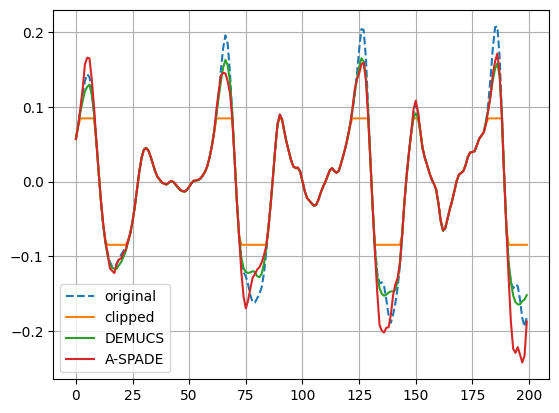

In [26]:
import matplotlib.pyplot as plt
# print(waveform.numpy()[0])
indices = range(10000,10200)
plt.plot(waveform.numpy()[0][indices], '--', label='original')
plt.plot(waveform_clipped.numpy()[0][indices], label='clipped')
plt.plot(waveform_demucs[0][indices], label='DEMUCS')
plt.plot(waveform_spade[0][indices], label='A-SPADE')
plt.legend()
plt.grid()